# Quantum Control via Commutative Pop Opt with Unitary Preserving Pade Approximation for Magnus expansion

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.linalg import expm, logm
from sympy.physics.quantum.dagger import Dagger
from qutip import propagator, Qobj
from sympy import I, eye, Rational, symbols, lambdify, sympify, Matrix, integrate, re
from ncpol2sdpa import generate_variables, SdpRelaxation

# Constructing a quantum system

Generate a quantum system with the hamiltonian
$\hat{H}(t) = \hat{H}_0 + u(t) \hat{V}$,
where $u(t)$ is a control field.

In [2]:
# Quantum system is taken from https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

# Drift Hamiltonian 
H0 = np.array([[0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 3.21505101e+10+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 6.23173079e+10+0.j]])

# Normalize the drift Hamiltonian by its maximum.
# This normalization factor can be accounted for by rescaling the time.
H0 /= H0.max()


# Control Hamiltonian
V = np.array([[0.        +0.j, 1.        +0.j, 0.        +0.j],
       [1.        +0.j, 0.        +0.j, 1.41421356+0.j],
       [0.        +0.j, 1.41421356+0.j, 0.        +0.j]])

# Normalize the control Hamiltonian by its maximum.
# This normalization factor can be accounted for by rescaling the control field.
V /= V.max()


In [3]:
# convert to sympy matrix
H0 = Matrix(H0)
V = Matrix(V)

In [4]:
# final time
T = 1

# Define control $u(t)$

Declear unknowns

In [5]:
x = generate_variables('x', 3)

Declare time variables

In [6]:
t, t1, t2, t3 = symbols('t, t1, t2, t3', real=True)

Postulate the polynomial shape for controls

In [7]:
u = lambdify(t, sum(c * t ** n_ for n_, c in enumerate(x)))
u(t)

t**2*x2 + t*x1 + x0

In [8]:
np.random.seed(8262021)

x_test = dict(zip(x, np.random.uniform(-1, 1, len(x))))
u_test = lambdify(t, u(t).subs(x_test))

Get the exact propagator using QuTip

In [9]:
U_target = propagator(
    [Qobj(np.array(H0, dtype=np.complex)), 
     [Qobj(np.array(V, dtype=np.complex)), str(u_test(t))]], T,
)

# Magnus expansion

Define generator of motion (i.e., Hamiltonian / I)

In [10]:
def A(u, t):
    return (H0 + V * u(t)) / I

Check whether the Magnus series converges by verifying that $\int _{0}^{T}\| \hat{A}(s) \|_{2}\,ds<\pi $

In [11]:
assert integrate( A(u_test, t1).norm(), (t1, 0, T)).evalf() < np.pi, \
    "Magnus series does not converge"

Define terms in the Magnus series

In [12]:
def Commutator(a, b):
    return a @ b - b @ a

def get_Magnus_expansion(u):
    A1 = A(u, t1)
    A2 = A(u, t2)
    A3 = A(u, t3)
    
    Omega1 = integrate(A1, (t1, 0, T))
    
    Omega2 = Rational(1, 2) * integrate(integrate(
        Commutator(A1, A2),
        (t2, 0, t1)), (t1, 0, T)
    )

    Omega3 = Rational(1, 6) * integrate(integrate(integrate(
        Commutator(A1, Commutator(A2, A3))
        + Commutator(Commutator(A1, A2), A3),
        (t3, 0, t2)), (t2, 0, t1)), (t1, 0, T)
    )

    return Omega1, Omega2, Omega3

def truncated_Magnus(u):
    Omegas = get_Magnus_expansion(u)
    
    return Omegas[0] if len(Omegas) == 1 else reduce(lambda x, y: x + y, Omegas)

In [13]:
Omegas = get_Magnus_expansion(u_test)

Calculate the norms of each term in the Magnus expansion – it really converges

In [14]:
[_.norm() for _ in Omegas]

[1.25458362517900, 0.00724194216959389, 0.000897440104548722]

Sum the truncated Magnus expansion and get its norm 

In [15]:
Omega = reduce(lambda x, y: x + y, Omegas)
Omega.norm()

1.25456869376850

Get the Magnus propagator

In [16]:
U_magnus = expm(np.array(Omega, dtype=np.complex))

Compare the exact propagator with Magnus

In [17]:
(U_target - U_magnus).norm()

6.944976104525545e-05

Evaluating Matrix exponent by unitarily preserving Made approximation (i.e., the Claye transform)
$$
    \exp \Omega = \frac{1 + \tanh(\Omega/2)}{1 - \tanh(\Omega/2)}, \\
    \tanh(\Omega/2) = (\Omega_1 + \Omega_2 )/2 + O\left(\| \Omega_3 \|_F\right), \\
    \tanh(\Omega/2) = (\Omega_1 + \Omega_2 + \Omega_3 )/2 - \Omega_1^3 / 24 + O\left(\| \Omega_4 \|_F\right).
$$

In [18]:
ident = eye(Omega.shape[0])

U_magnus_pade = (ident + Omega / 2 - Omegas[0] ** 3 / 24) \
                @ (ident - Omega / 2 + Omegas[0] ** 3 / 24).inv()
U_magnus_pade = U_magnus_pade.simplify()

In [19]:
(U_target - U_magnus_pade).norm()

0.0147539767727780

In [20]:
(U_magnus - U_magnus_pade).norm()

0.0147519323471524

# Construct commutative polynomial optimization problem for solving quantum control

$$
P_3 [u(t)] = \left\| 1 - \hat{U}_{T} + \left(1 + \hat{U}_{T}\right) \frac{\Omega_1 + \Omega_2}{2}
    \right\|_F, \notag\\
P_4 [u(t)] = \left\| 1 - \hat{U}_{T} + \left(1 + \hat{U}_{T}\right) \left(\frac{\Omega_1 + \Omega_2 + \Omega_3}{2} - \frac{\Omega_1^3}{24}\right)
    \right\|_F.
$$

In [21]:
Omegas = get_Magnus_expansion(u)

#P3 = (
#    ident - U_target + (ident + U_target) @ (Omegas[0] + Omegas[1]) / 2
#).norm() ** 2

P4 = (
    ident - U_target + (ident + U_target) @ (
        (Omegas[0] + Omegas[1] + Omegas[2]) / 2 - Omegas[0] ** 3 / 24
    )
).norm() ** 2


Run Optimization

In [22]:
sdp = SdpRelaxation(x)
sdp.get_relaxation(5, objective=re(P4))
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    opt_x = {_:sdp[_] for _ in sdp.variables}
    
    u_opt = lambdify(t, u(t).subs(opt_x))
else:
    opt_x = {}
    u_opt = None

Control pulse found via the polynomial optimization

In [23]:
u_opt(t)

-4.55284187860596*t**2 + 4.43907033935201*t - 1.03054133006874

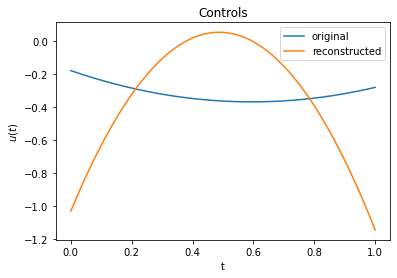

In [24]:
times = np.linspace(0, T, 500)

plt.title('Controls')
plt.plot(times, u_test(times), label='original')
plt.plot(times, u_opt(times), label='reconstructed')
plt.ylabel('$u(t)$')
plt.xlabel('t')
plt.legend()
plt.show()

Obtain the unitary that the found control synthesized  

In [25]:
U_opt = propagator(
    [Qobj(np.array(H0, dtype=np.complex)), 
     [Qobj(np.array(V, dtype=np.complex)), str(u_opt(t))]], T,
)

Comparing the synthesized and target unitaries

In [26]:
(U_target - U_opt).norm()

0.013367386645219907